# Predictive Maintenance in Robotic Systems

In this notebook, we will analyze sensor data from a robotic system and train a **Random Forest** model to predict potential faults.

## 1. Import Libraries and Load Data
First, we import the necessary libraries for data analysis, visualization, and machine learning, and then we load our dataset.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## 2. Data Preparation & Basic Statistics
We separate the target variable (`fault`), which indicates whether there is a malfunction or not. Next, we extract the basic descriptive statistics of our metrics to get an initial feel for the data (mean, standard deviation, min/max, etc.).

In [9]:
df = pd.read_csv("Robo_metrics.csv")
print(df.head())

       max      min      mean        sd       rms  skewness  kurtosis  \
0  0.35986 -0.41890  0.017840  0.122746  0.124006 -0.118571 -0.042219   
1  0.46772 -0.36111  0.022255  0.132488  0.134312  0.174699 -0.081548   
2  0.46855 -0.43809  0.020470  0.149651  0.151008  0.040339 -0.274069   
3  0.58475 -0.54303  0.020960  0.157067  0.158422 -0.023266  0.134692   
4  0.44685 -0.57891  0.022167  0.138189  0.139922 -0.081534  0.402783   

      crest      form       fault  
0  2.901946  6.950855  Ball_007_1  
1  3.482334  6.035202  Ball_007_1  
2  3.102819  7.376926  Ball_007_1  
3  3.691097  7.558387  Ball_007_1  
4  3.193561  6.312085  Ball_007_1  


In [10]:
#keep the column fault seperately 
df_fault = df['fault']

df = df.drop(columns=["fault"], errors="ignore")
print(df.head())

       max      min      mean        sd       rms  skewness  kurtosis  \
0  0.35986 -0.41890  0.017840  0.122746  0.124006 -0.118571 -0.042219   
1  0.46772 -0.36111  0.022255  0.132488  0.134312  0.174699 -0.081548   
2  0.46855 -0.43809  0.020470  0.149651  0.151008  0.040339 -0.274069   
3  0.58475 -0.54303  0.020960  0.157067  0.158422 -0.023266  0.134692   
4  0.44685 -0.57891  0.022167  0.138189  0.139922 -0.081534  0.402783   

      crest      form  
0  2.901946  6.950855  
1  3.482334  6.035202  
2  3.102819  7.376926  
3  3.691097  7.558387  
4  3.193561  6.312085  


In [11]:
stats = df.describe().T 
print("Statistics:",stats)

Statistics:            count       mean        std       min       25%        50%  \
max       2300.0   1.575079   1.578422  0.157300  0.456398   0.794510   
min       2300.0  -1.550994   1.602706 -6.292600 -2.174975  -0.733700   
mean      2300.0   0.015711   0.006469  0.003246  0.011236   0.013730   
sd        2300.0   0.341601   0.305279  0.059140  0.135506   0.188551   
rms       2300.0   0.342289   0.304813  0.061067  0.136374   0.190662   
skewness  2300.0  -0.042251   0.180774 -1.089928 -0.103426  -0.002466   
kurtosis  2300.0   2.664444   4.411096 -0.803795 -0.015164   0.816970   
crest     2300.0   4.173130   1.148349  2.428511  3.260382   3.921650   
form      2300.0  26.544769  29.209702  3.484429  7.413359  13.122811   

                75%         max  
max        2.278425    6.825900  
min       -0.426987   -0.160220  
mean       0.018638    0.038386  
sd         0.555589    1.256577  
rms        0.555671    1.256311  
skewness   0.061093    1.059512  
kurtosis   3.902286

## 3. Visualization: Feature Distributions
It is important to understand how the values of each sensor/metric are distributed. We will create histograms with Kernel Density Estimation (KDE) for each numerical variable.

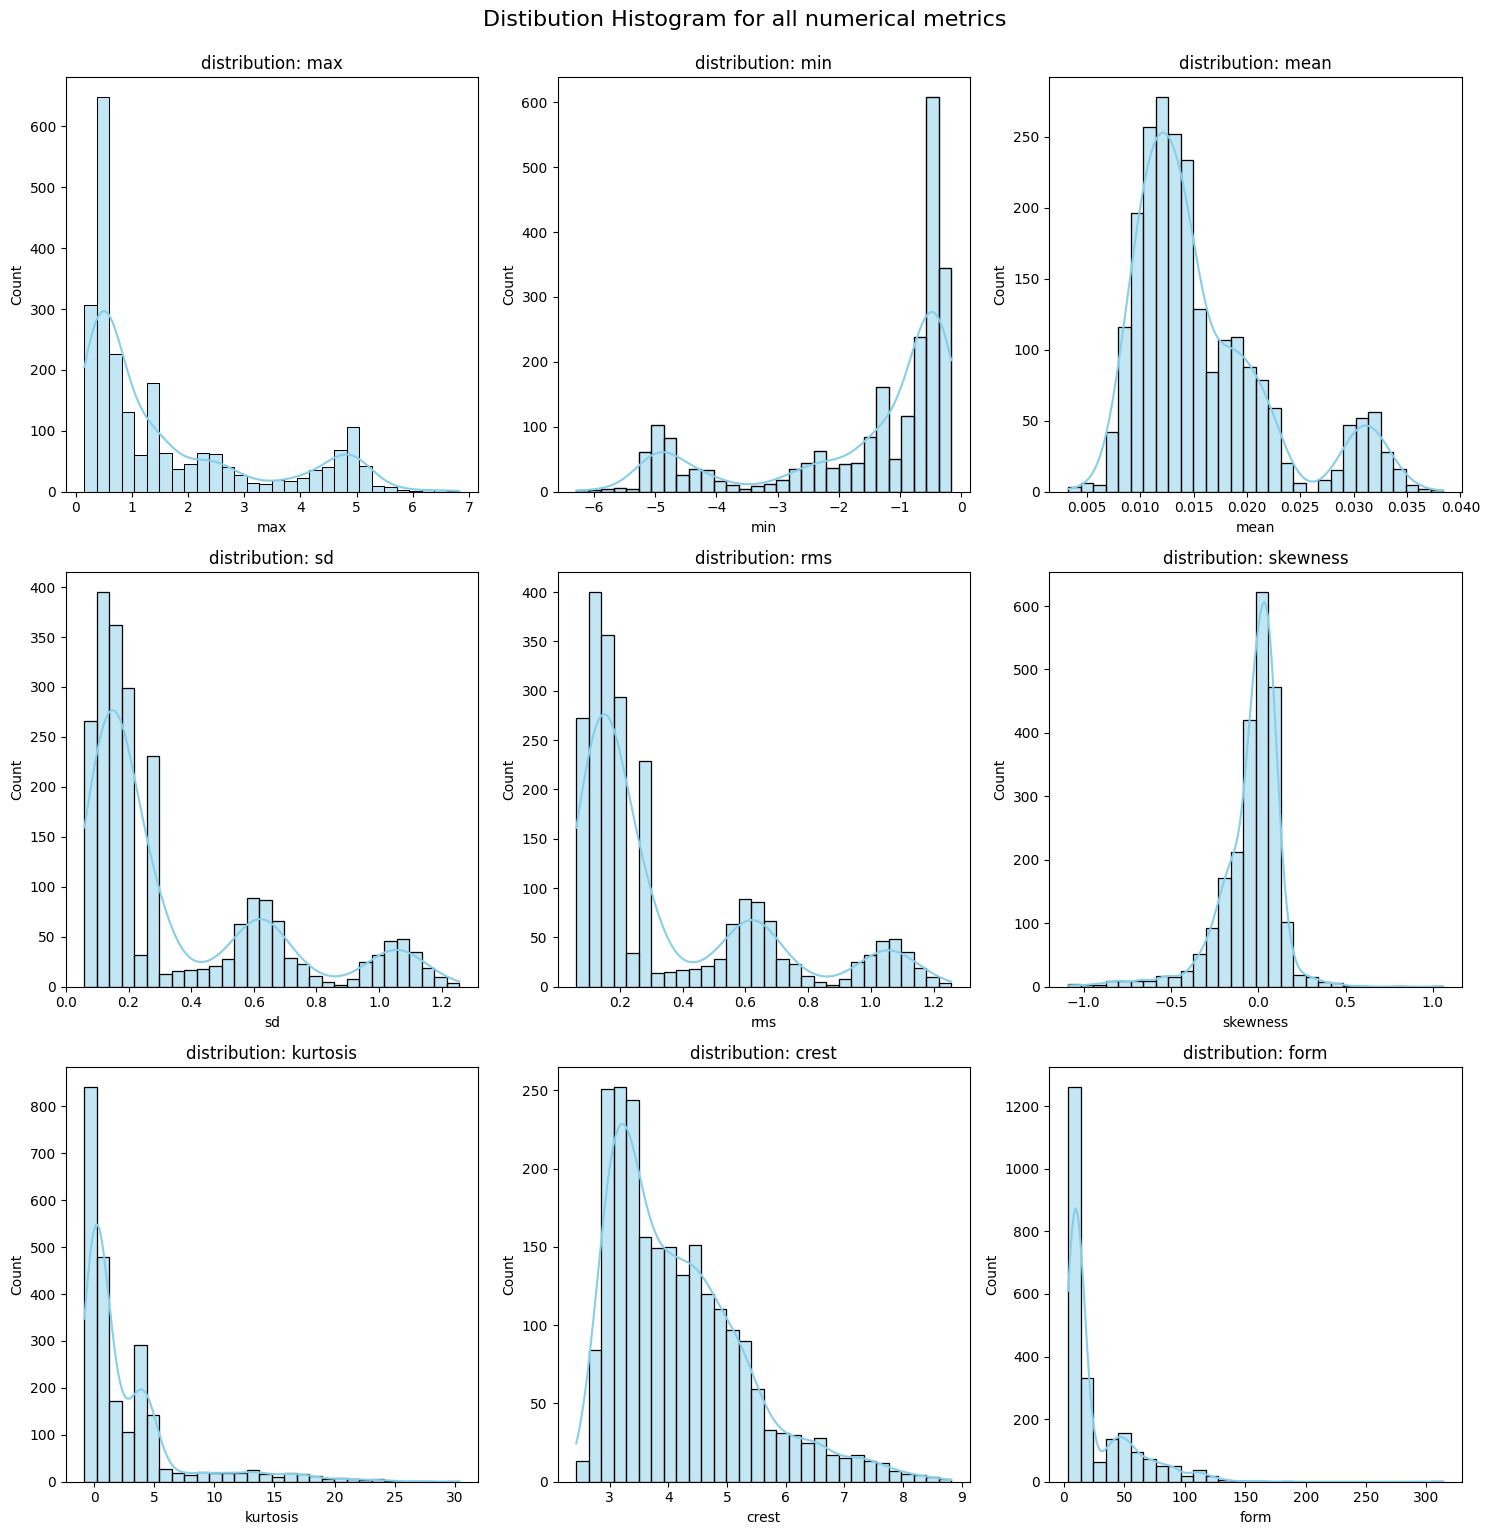

In [12]:
n_rows = 3
n_cols = 3
plt.figure(figsize=(15, 15))

for i, col in enumerate(df):
    plt.subplot(n_rows, n_cols, i + 1)
    # Χρησιμοποιούμε histplot με kde (εκτίμηση πυκνότητας πυρήνα) για ομαλή γραμμή
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'distribution: {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.tight_layout()

plt.suptitle('Distibution Histogram for all numerical metrics', fontsize=16, y=1.02)
plt.show()

plt.savefig('numerical_histograms.png')
plt.close()

## 4. Feature Correlation (Correlation Matrix)
With the correlation matrix (Heatmap), we can see if certain metrics are strongly correlated with each other (e.g., if the increase of one always means the increase of another). This helps us identify redundant information.

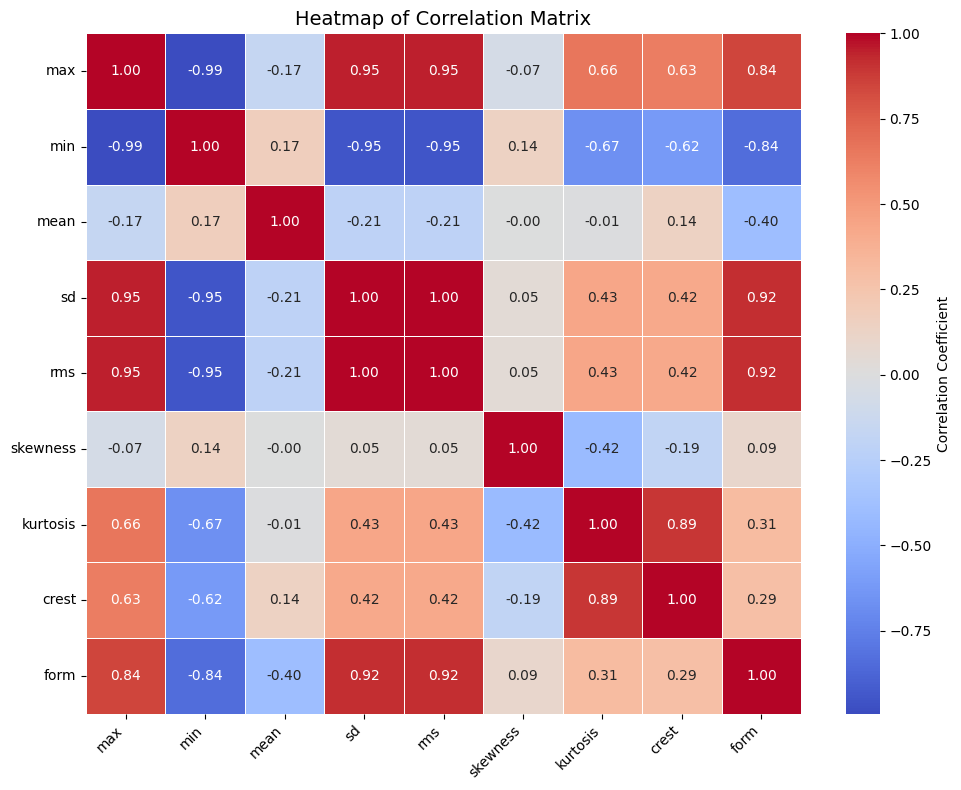

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,          # Εμφάνιση των τιμών συσχέτισης
    fmt=".2f",           # Μορφοποίηση σε 2 δεκαδικά ψηφία
    cmap='coolwarm',     # Χρωματικός χάρτης (Cool-Warm)
    linewidths=.5,       # Γραμμές μεταξύ των κελιών
    cbar_kws={'label': 'Correlation Coefficient'} # Ετικέτα για τη χρωματική μπάρα
)
plt.title('Heatmap of Correlation Matrix', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

## 5. Data Normalization (Standardization)
Machine learning algorithms perform better when the data is on the same scale. Here, we use the `StandardScaler` to transform the data so that it has a mean of 0 and a standard deviation of 1 (z-score normalization). We then create a BoxPlot to confirm the transformation.

In [15]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)
print("Normalized Data (Standard Scaling):")

Normalized Data (Standard Scaling):


C:\Users\pkiaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\pkiaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\pkiaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (10) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
C:\Users\pkiaz\AppData\Local\Packages\Py

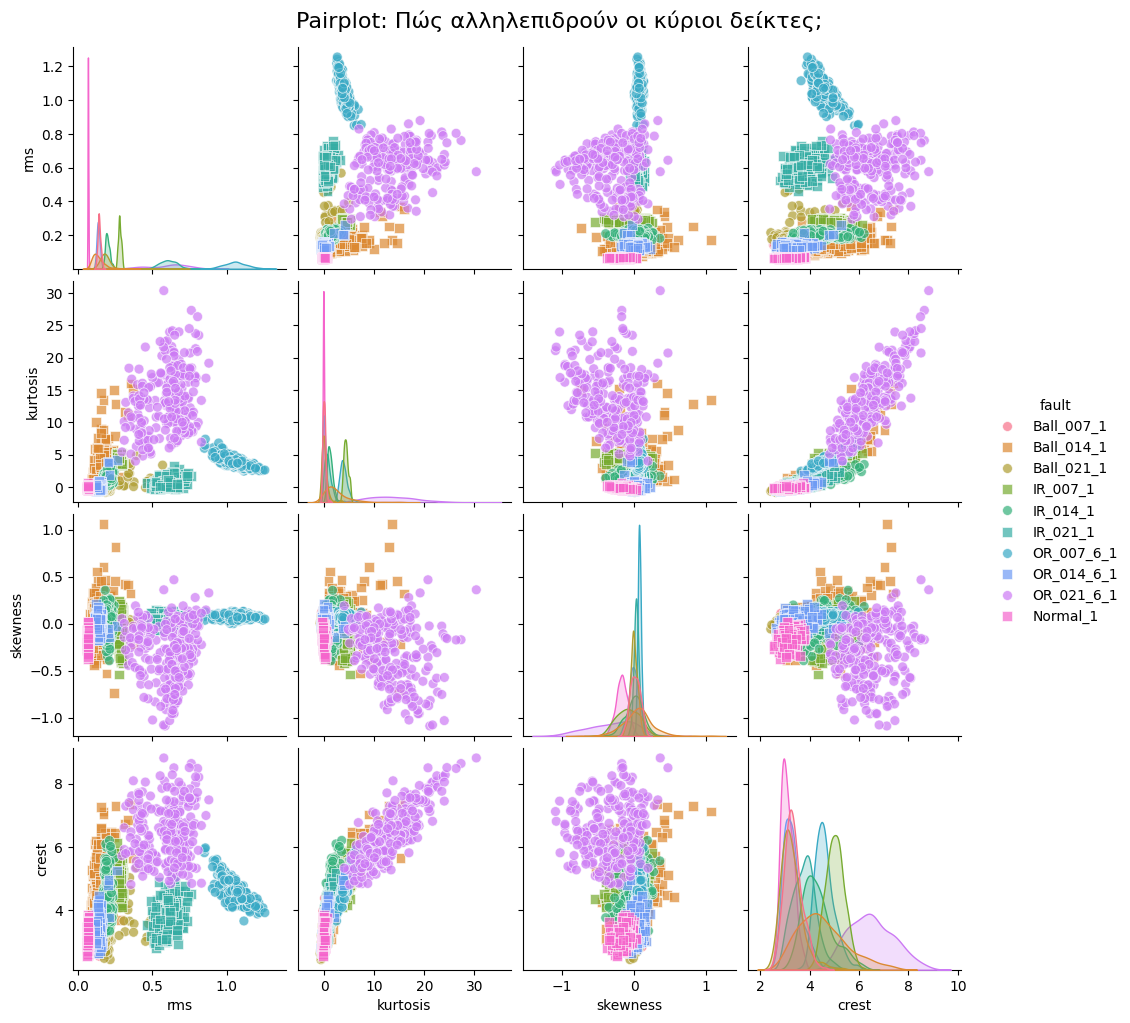

In [18]:
# Ενώνουμε προσωρινά τη στήλη fault με τα δεδομένα για το γράφημα
df_eda = df.copy()
df_eda['fault'] = df_fault.values

top_features = ['rms', 'kurtosis', 'skewness', 'crest', 'fault']

# Φτιάχνουμε το pairplot
g = sns.pairplot(
    df_eda[top_features], 
    hue='fault', 
    palette='husl', 
    markers=["o", "s"], 
    plot_kws={'alpha': 0.7, 's': 50}, # Διαφάνεια και μέγεθος κουκκίδων
    diag_kind='kde' # Στη διαγώνιο βάζουμε καμπύλες πυκνότητας
)

g.fig.suptitle("Pairplot: Πώς αλληλεπιδρούν οι κύριοι δείκτες;", y=1.02, fontsize=16)
g.savefig('pairplot_top_features.png')
plt.show()

### Interpreting the Pairplot

This diagram (Pairplot) is used to visualize how the 4 main statistical indicators (`rms`, `kurtosis`, `skewness`, `crest`) extracted from the robot's vibration signal correlate with each other, and how well they separate the different types of faults (e.g., bearing faults like Ball, Inner Race, Outer Race).

**1. What the axes represent:**
* **RMS (Root Mean Square):** Indicates the average power of the signal (overall vibration).
* **Kurtosis:** Shows how "sharp" the peaks are (ideal for detecting impacts/shocks).
* **Skewness:** Indicates the asymmetry of the signal's distribution.
* **Crest (Crest Factor):** The ratio of the peak value to the RMS (useful for early signs of failure).

**2. How to read the graph:**
* **On the diagonal (KDE Distributions):** We see the density of each variable separately. The more the "hills" of different colors (faults) separate from each other, the better that indicator is for classification.
* **In the other squares (Scatter Plots):** We see the data dispersion. We are looking for color "clusters".

**3. Key Takeaways:**
* **Separation:** Certain faults (e.g., Outer Race) stand out very easily from the rest, especially when looking at the `rms` axis.
* **Normal Operation:** In the `rms` vs `crest` plot, the "normal" state tends to cluster low and to the left, which is expected for a healthy machine.
* **Correlation:** A strong linear relationship is often observed (e.g., between `kurtosis` and `crest`); meaning when one increases, the other generally increases as well.
* **Classification Difficulty:** Faults like "Ball faults" often overlap with each other in the center of the plots. **This is exactly why we need powerful Machine Learning algorithms (like Random Forest / XGBoost)** to find the complex decision boundaries that the human eye cannot clearly see!

## 6. Dimensionality Reduction with PCA
To visualize in a 2D space whether the "faults" stand out from "normal operation", we use Principal Component Analysis (PCA). PCA compresses the information from all sensors into 2 main axes (PC1 and PC2).

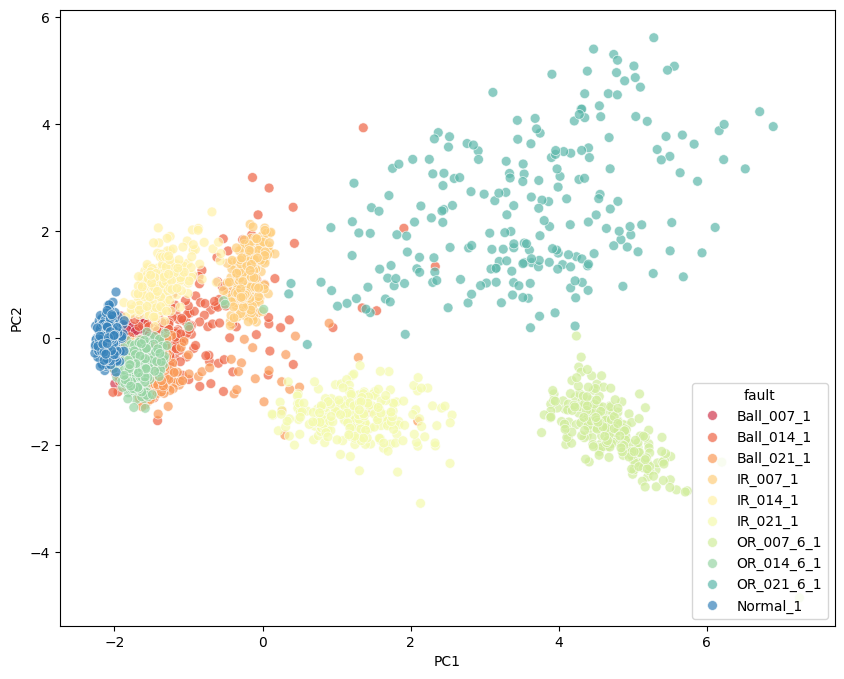

Explained variance ratio: [0.60717858 0.19327158]
Total explained variance: 0.8004501503925343


In [17]:
# Apply PCA and transform the data (ΜΟΝΟ στα αριθμητικά δεδομένα)
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(normalized_data)

df_pca = pd.DataFrame(data = principal_comp , columns= ['PC1', 'PC2'])
df_pca['fault'] = df_fault # <-- Η 'fault' προστίθεται εδώ ξανά!

# Scatter Plot (Χρήση της 'fault' για το hue)
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue ='fault', 
    data = df_pca, 
    palette='Spectral',
    s=50,
    alpha=0.7
    )
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())



## 7. Model Training (Random Forest)
In this stage:
1. We convert the labels ('fault') into numerical format using `LabelEncoder`.
2. We split our data into a training set (75%) and a testing set (25%).
3. We train a **Random Forest** algorithm (an ensemble of Decision Trees).

In [21]:
selected_features = df[['rms', 'kurtosis', 'skewness', 'crest']]

le = LabelEncoder()
y = le.fit_transform(df_fault)


In [22]:
# train / test split 
X = normalized_data
X_train , X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.25,random_state=2, stratify=y
)

In [28]:
#Baseline classifier - RandomForest 
clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


## 8. Model Evaluation & Feature Importance
To see how well our model performed, we print the Classification Report and create a **Confusion Matrix** to see where the errors are happening. Finally, we look at which metrics were the most "important" for the algorithm.

--- Classification Report ---
              precision    recall  f1-score   support

  Ball_007_1       0.95      0.93      0.94        57
  Ball_014_1       0.90      1.00      0.95        57
  Ball_021_1       0.93      0.86      0.89        58
    IR_007_1       0.98      1.00      0.99        58
    IR_014_1       1.00      1.00      1.00        57
    IR_021_1       0.98      1.00      0.99        57
    Normal_1       1.00      1.00      1.00        58
  OR_007_6_1       1.00      1.00      1.00        57
  OR_014_6_1       0.86      0.83      0.84        58
  OR_021_6_1       1.00      0.98      0.99        58

    accuracy                           0.96       575
   macro avg       0.96      0.96      0.96       575
weighted avg       0.96      0.96      0.96       575



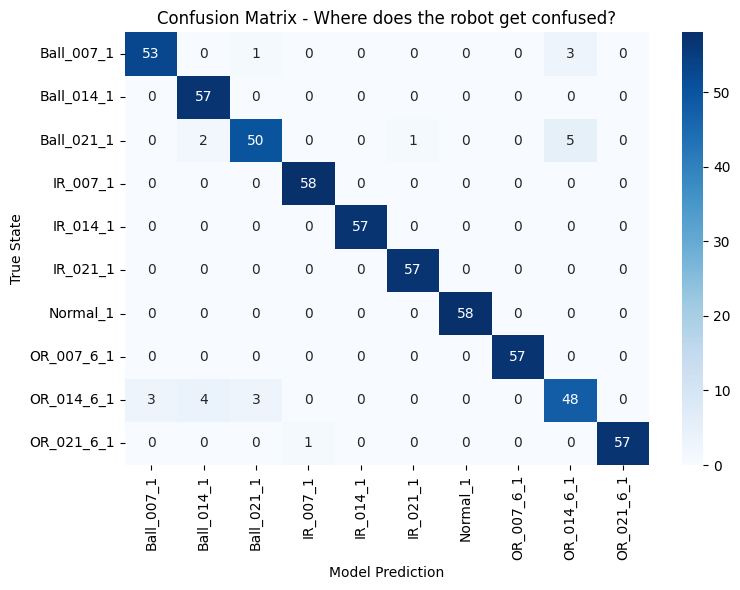

C:\Users\pkiaz\AppData\Local\Temp\ipykernel_26056\1937763011.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


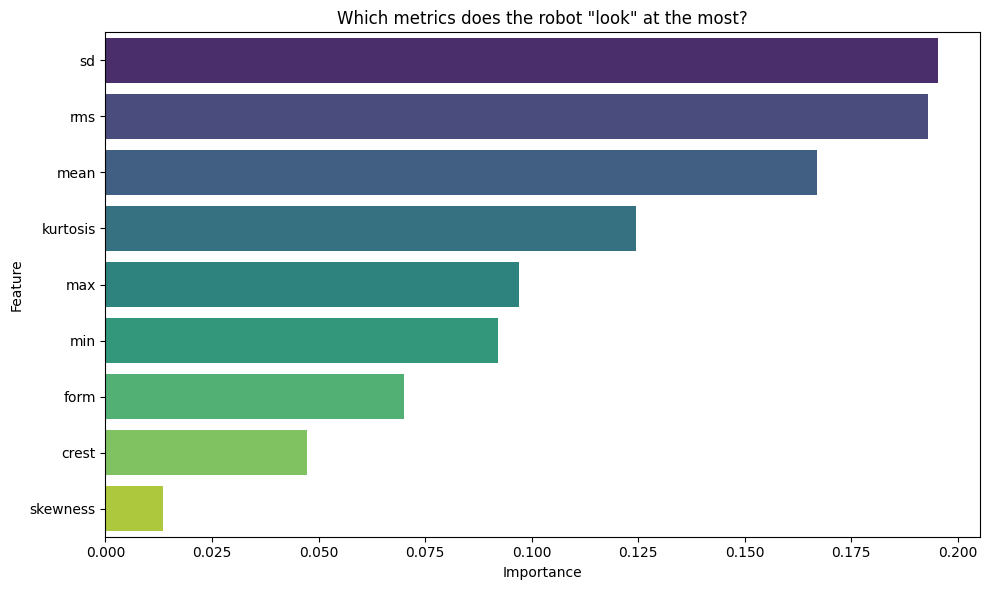

In [ ]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 1. Confusion Matrix Visualization  
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Where does the robot get confused?')
plt.xlabel('Model Prediction')
plt.ylabel('True State')
plt.tight_layout()
plt.savefig('confusion_matrix_heatmap.png')
plt.show()

# 2. Feature Importance Visualization
importances = clf.feature_importances_
feature_names = df.columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Which metrics does the robot "look" at the most?')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

## 9. Save the Model
Now that we have trained and evaluated the model, we save it along with the Scaler and the LabelEncoder. This allows us to load them later in a production environment to make real-time predictions (inference).

In [29]:
import joblib 

joblib.dump(clf, 'robotic_maintenance_model.pkl')
joblib.dump(scaler, 'data_scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("Success! The model (clf) and transformers (scaler, encoder) were saved successfully.")

Success! The model (clf) and transformers (scaler, encoder) were saved successfully.
